#Regularisation and Optimisation
This assignment investigates training of CNNs on CIFAR with a goal of maximising accuracy.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a dataset with small size (32x32) images and 50k training samsamples.
* It is often used as a "Hello World" type data set to setup a training pipeline. As it is relatively fast to train a network with CIFAR-10, this dataset is also widely used for running comparison or optimisation experiments. For example comparing different networks, regularisation methods or optimisers. (In pytorch the CIFAR-10 dataset is available as a [pytorch dataset](https://pytorch.org/vision/0.18/generated/torchvision.datasets.CIFAR10.html) simplifying loading the dataset.)

The starting point in this assignment is an untrained convolutional neural network.
* You will not modify the structure of the network. (We will discuss network structures in more detail in section 2 of module).
* The network has sufficient capacity (Parameters/FLOPS) to achieve high accuracy.
* The notebook (starting configurataion) will train the model without regularisation and using the SGD optimiser. From inspection of the training/validation accuracy/loss, it will be observed that the network is ovefitting.
* You will improve the performance of the network using regularisation techniques (See below).
* The goal is to use one or several techniques to prevent overfitting and maximse test accuracy.

Regularisation techniques.
* [Data Augmentation using pytorch transforms](https://pytorch.org/vision/0.15/transforms.html)
* Regularisation layers such as [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and [batch normalisation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

The learning rate also acts as a regulariser, with large learning rates having a regularising effect. You may also include a LR schedule as detailed in the [pytorch optim package](https://pytorch.org/docs/stable/optim.html). The optim package contains several implementations of LR schedules including those detailed in the papers:
* [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186)
* [Super-Convergence: Very Fast Training of Neural
Networks Using Large Learning Rates](https://arxiv.org/pdf/1708.07120)


How to approach this Assignment.
* There are a lot things to try and possible approaches. Keep a table of what you have tried. Apart from recording training and test accuracy, Ensure that you record the key hyperparameters, including optimiser, base learning rate, number of epochs for each run. This makes repeating experiments possible if you want to try a variation.
* Your final submitted notebook should include your best attempt showing training curves and a comment on your approach. (Do not submit a notebook with multiple approaches)


In [1108]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad
import matplotlib.pyplot as plt
import numpy as np

import os
from torchinfo import summary
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassAccuracy


In [1109]:
#!pip install torchinfo

In [1110]:
#!pip install torchmetrics

In [1111]:
#!pip install numpy

In [1112]:
#!pip install tensorboard
# url to see the data http://localhost:6006/?darkMode=true#timeseries

In [1113]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

if device == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("CuDNN benchmark mode ENABLED") # since we have a fixed input of images may as well put the machine to work - faster convolution


Using cuda device
CuDNN benchmark mode ENABLED


In [1114]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def fetch_accuracy(y_true, y_pred):

    acc_A = accuracy_score(y_true, y_pred)
    f1_macro_A = f1_score(y_true, y_pred, average='macro')

    print(f"Model A → Acc: {acc_A:.3f}, Macro-F1: {f1_macro_A:.3f}")

def fetch_train_object(batch_size, num_workers, pin_memory) :

    train_transforms = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
        ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=train_transforms)

    train_dataloader = DataLoader(training_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory,
                                  prefetch_factor=4,      # range 2- 8
                                  persistent_workers=True)

    print('Train Samples ',len(train_dataloader.dataset))
    print('Train Batches ',len(train_dataloader))

    return train_transforms, training_data, train_dataloader

def fetch_test_object(batch_size, num_workers, pin_memory):

    test_transforms = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
        ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    test_data = datasets.CIFAR10(
            root="data",
            train=False,
            download=True,
            transform=test_transforms)

    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=pin_memory,
                                 prefetch_factor=4,      # range 2- 8
                                 persistent_workers=True)

    print('Test Samples ',len(test_dataloader.dataset))
    print('Test Batches ',len(test_dataloader))

    return test_transforms, test_data, test_dataloader

In [1115]:
batch_size = 128 # to speed up things  256
num_workers = min(8, os.cpu_count() or 1)
pin_memory = (device == 'cuda')

train_transforms, training_data, train_dataloader = fetch_train_object(batch_size, num_workers, pin_memory)
test_transforms, test_data, test_dataloader = fetch_test_object(batch_size, num_workers, pin_memory)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Train Samples  50000
Train Batches  391
Test Samples  10000
Test Batches  79
Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
Shape of y: torch.Size([128]) torch.int64


In [1116]:
#print('Test Samples ',len(test_dataloader.dataset))
#print('Train Samples ',len(train_dataloader.dataset))
#print('Test Batches ',len(test_dataloader))
#print('Train Batches ',len(train_dataloader))

In [1117]:
# Output next batch from dataloader
#dataiter = iter(train_dataloader)
#image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

#i=0
#n_plots = 12 # number of plots
#f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

#for image in image_batch[0:n_plots,:,:,:]:
#  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
#  mean = np.array([0.485, 0.456, 0.406])
#  std = np.array([0.229, 0.224, 0.225])
#  disp_image = std * disp_image + mean
#  disp_image = np.clip(disp_image, 0, 1)
#  axarr[i].imshow(disp_image[:,:,:])
#  axarr[i].axis("off")
#  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
#  i = i+1

# Define CNN Model

To define a neural network in PyTorch, we create a class that inherits ([see python inheritance](https://www.w3schools.com/python/python_inheritance.asp))
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU.

A simple CNN is defined using [2D convolution](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [2D max pooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html). [Relu activiation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is applied after the convolution layers. The output of the last convolution is [flattened](https://pytorch.org/docs/stable/generated/torch.flatten.html) and [2 linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (dense) layers applied. Only activiation is applied after the first linear layer. As seen in the next section when setting up our loss function we use the form `_from_logits` so the optimiser will know that softmax activiation needs to be applied. (Alternatively we can directly apply [softmax activiation](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html))

* **You do not need to modify the network architecture**. You can add regularisation layers and adjust the optimisation/learning rate schedule which is a further method of regularisation in later code cells.

In [1118]:
# -- model --

In [1119]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.simple_cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding='same'),   # by having 2 conv we are looking for more features to extract
            nn.BatchNorm2d(32),
            nn.ReLU(),                            # convert negative to a 1
            nn.Conv2d(32,64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # downsampling
            nn.Dropout(0.2),

            nn.Conv2d(64,64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # downsampling
            nn.Dropout(0.4),

            nn.Conv2d(64,128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2), # downsampling
            nn.Dropout(0.4),

            nn.AdaptiveAvgPool2d(1),                # replace the old ways of VGG with gold standard (brings parameters down from 5k to 1k)
            nn.Flatten(),                           # classificatio
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 10)
        )

    def forward(self, x):

        logits = self.simple_cnn(x)
        return logits

model = NeuralNetwork().to(device)
summary(model,
        input_size=(1, 3, 32, 32),           # (batch, channels, H, W)
        depth=4,
        device=device
    )

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Dropout: 2-8                      [1, 64, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 64, 16, 16]           36,928
│    └─BatchNorm2d: 2-10                 [1, 64, 16, 16]           128
│    └─ReLU: 2-11                        [1, 64, 16, 16]           --
│   

# Optimisation & Training Loop

For this classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* The SGD (Stocasitc Gradient Descent) Optimiser is provided as a the default training configuration. As the learning rate is fixed, this may not be optimal as training progresses for finding the global minimum.

* Note that you can interrupt the training if it has converged (or failed) and then view the tensorboard curves and also obtain accuracy of the test set (by running the appropriate cells).

* Make sure to run the model call and optimiser call before starting training again to ensure the previous training state is cleared.

[Tensorboard is imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.


In [1120]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,  weight_decay=1e-6, momentum=0.9)


Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb))


In [1121]:
from torch.utils.tensorboard import SummaryWriter
import time

run_name = f"exp_{int(time.time())}"
writer = SummaryWriter(log_dir=f"runs/{run_name}")

In [1122]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',          # minimize validation loss
    factor=0.5,          # new_lr = lr * factor
    patience=10,          # number of *validation* checks with no improvement
    min_lr=1e-6
)

In [1123]:
#%rm -rf runs/exp_17*

Training & Validataion Loop

In [1124]:

n_iter =100   # Set how frequently will return loss (must be less than test_size)
n_epochs = 20 # Set total number of epoochs

train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
num_test_batches = len(test_dataloader)

best_vloss = float('inf')
patience = 10
min_delta = 1e-4
stop_training = False
wait_counter = 0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    if stop_training:
        break

    running_loss = running_acc = 0.0

    for i, data in enumerate(train_dataloader, 0):

        # input and labels are pushed to the correct device
        inputs, labels = [x.to(device) for x in data]

        outputs = model(inputs)            # forward pass
        loss = loss_fn(outputs, labels)    # compute loss
        loss.backward()                    # compute gradient

        optimizer.step()                   # update model based on gradient
        optimizer.zero_grad()              # reset gradient

        running_loss += loss.item()
        running_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        if i % n_iter == n_iter-1:    # Every n mini-batches...

            running_vloss = running_vacc = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer

            model.eval()
            for j, vdata in enumerate(test_dataloader, 0):

                vinputs, vlabels = [x.to(device) for x in vdata]

                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)

                running_vloss += vloss.item()
                running_vacc += (voutputs.argmax(1) == vlabels).type(torch.float).sum().item()

            model.train()

            avg_loss = running_loss / n_iter                # Compute loss over n_iter iterations
            avg_acc = 100*running_acc / (n_iter*batch_size) # number of examples computing accuracy over
            avg_vloss = running_vloss / num_test_batches
            avg_vacc = 100*running_vacc / test_size

            scheduler.step(avg_vloss)

            running_loss = 0.0
            running_acc = 0.0

            current_lr = optimizer.param_groups[0]['lr']
            global_step_index = epoch * len(train_dataloader) + i
            writer.add_scalar('Learning Rate', current_lr, global_step_index)
            writer.add_scalars('Loss',     {'Training Loss' : avg_loss, 'Validation Loss' : avg_vloss }, global_step_index)
            print(f"\nStep {global_step_index:03d} — Gap (train-val): {avg_loss-avg_vloss:.4f}")
            writer.add_scalars('Accuracy', {'Training Acc'  : avg_acc, 'Validation Acc'   : avg_vacc  }, global_step_index)

            #if avg_vloss < best_vloss - min_delta:
            #    best_vloss = avg_vloss
            #    writer.add_scalar('Best vloss', best_vloss, global_step_index)
            #    wait_counter = 0
            #else:
            #    wait_counter += 1
            #    if wait_counter >= patience:
            #        stop_training = True
            #       break

print('Finished Training')

writer.flush()
writer.close()


Step 099 — Gap (train-val): -0.2716

Step 199 — Gap (train-val): -0.0830

Step 299 — Gap (train-val): 0.0677

Step 490 — Gap (train-val): -0.2638

Step 590 — Gap (train-val): 0.0094

Step 690 — Gap (train-val): -0.1213

Step 881 — Gap (train-val): -0.0830

Step 981 — Gap (train-val): -0.0357

Step 1081 — Gap (train-val): -0.0027

Step 1272 — Gap (train-val): -0.1207

Step 1372 — Gap (train-val): -0.0942

Step 1472 — Gap (train-val): 0.0545

Step 1663 — Gap (train-val): -0.1524

Step 1763 — Gap (train-val): -0.0943

Step 1863 — Gap (train-val): -0.0024

Step 2054 — Gap (train-val): -0.0412

Step 2154 — Gap (train-val): -0.0334

Step 2254 — Gap (train-val): 0.0142

Step 2445 — Gap (train-val): -0.1154

Step 2545 — Gap (train-val): 0.0181

Step 2645 — Gap (train-val): -0.0694

Step 2836 — Gap (train-val): -0.0312

Step 2936 — Gap (train-val): -0.0639

Step 3036 — Gap (train-val): -0.0277

Step 3227 — Gap (train-val): -0.0047

Step 3327 — Gap (train-val): -0.0515

Step 3427 — Gap (train-v

# Evaluate Model
We will obtain the classification report after final evaluation of the test dataset with the model. A confusion matrix can also be obtained and we will plot a few example images.

In [1125]:
import numpy as np

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

store_predictions = []
store_labels = []
model.eval()

for i, data in enumerate(test_dataloader, 0):
    # basic training loop
    input_batch, label_batch = data
    input_batch = input_batch.to(device)

    pred_logit = model(input_batch)
    predictions = torch.argmax(pred_logit,1) # reduce along output dimension
    predictions_np = predictions.to("cpu").numpy()
    label_batch_np = label_batch.numpy()
    if i<num_test_batches-1:
      store_predictions.append(predictions_np)
      store_labels.append(label_batch)

y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*batch_size)))

              precision    recall  f1-score   support

    airplane       0.81      0.89      0.85       998
  automobile       0.92      0.94      0.93       999
        bird       0.74      0.82      0.78       999
         cat       0.73      0.70      0.72       997
        deer       0.78      0.89      0.83      1000
         dog       0.87      0.70      0.78       997
        frog       0.90      0.89      0.89      1000
       horse       0.94      0.83      0.88       997
        ship       0.89      0.95      0.92       997
       truck       0.95      0.89      0.91      1000

    accuracy                           0.85      9984
   macro avg       0.85      0.85      0.85      9984
weighted avg       0.85      0.85      0.85      9984

Model A → Acc: 0.849, Macro-F1: 0.848


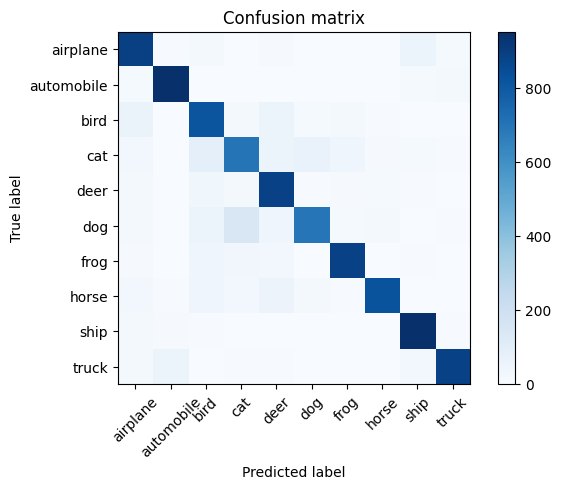

In [1126]:
print(classification_report(y_true, y_pred, target_names=classes))
fetch_accuracy(y_true, y_pred)
plot_confusion_matrix(confusion_matrix(y_true, y_pred))

In [1127]:
%tensorboard --logdir=runs --port=6006 --bind_all

Reusing TensorBoard on port 6006 (pid 39840), started 9:53:45 ago. (Use '!kill 39840' to kill it.)

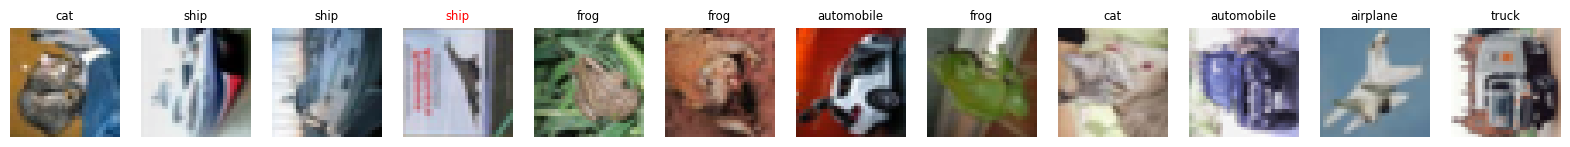

In [1128]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  predicted, actual = classes[pred_logit[i,:].argmax(0)], classes[labels_batch[i]]
  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1

 # Comments about your Approach